# Changepoint detection and deviation detection
Notebook containing experimental evaluation of soiling modelling methods.

In [1]:
import numpy as np
import os, sys
import math
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
%matplotlib inline 
#from my_functions import *
from modules.preprocessing import *
from modules.statistics import *
from modules.io import *
from modules.learning import *
from scipy import stats
from ast import literal_eval

#from modules.experiments import *
import matplotlib.dates as mdates


## Read data
Read input time series. Manual washing dates are given as input. 

In [2]:
def parse_csv(filename):
    df_meta = pd.read_csv(filename, nrows=1)
    df_temp = pd.read_csv(filename, sep='\n', header=None, names=["temp"])
    col_names = df_temp.temp.iloc[2].split(',')
    col_names.extend(['I-V Curve I Values', 'I-V Curve V Values'])
    rows = []
    num_r = df_temp.iloc[3:].shape[0]
    
    # handle columns
    for i in range(num_r):
        data = df_temp.temp.loc[3+i].split(',')
        N = int(data[41])
        rows.append(data[:42])
        rows[i].extend([np.array(data[42:42+N]), np.array(data[42+N:])])
    df = pd.DataFrame(columns=col_names, data=rows)
    
    # convert to datetime
    df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0], errors='coerce') 
    
    # convert to datetime.time (99:99 will be replaced with nan)
    df.iloc[:, 38] = pd.to_datetime(df.iloc[:, 38], format= '%H:%M', errors='coerce').dt.time
    df.iloc[:, 39] = pd.to_datetime(df.iloc[:, 39], format= '%H:%M', errors='coerce').dt.time
    
    # infer and convert to appropriate types for each column
    idx = [0, 38, 39, 42, 43]
    for j in range(1, df.shape[1]):
        if j in idx:
            continue
        df.iloc[:, j] = df.iloc[:, j].apply(literal_eval)
        
    # replace -9999 precipitation with nan
    idx1 = [x for x in list(range(df.shape[1])) if x not in idx]
    df.iloc[:, idx1] = df.iloc[:, idx1].replace(-9999, np.nan)
    
    return df_meta, df

Manual washing dates:

In [3]:
#filename = '/data/data1/data-for-validating-models/Data For Validating Models/Cocoa/Cocoa_CIGS39017.csv'
#filename = '/data/data1/data-for-validating-models/Data For Validating Models/Cocoa/Cocoa_mSi0188.csv'
filename = '/data/data1/data-for-validating-models/Data For Validating Models/Eugene/Eugene_mSi0188.csv'
#filename = '/data/data1/data-for-validating-models/Data For Validating Models/Golden/Golden_mSi0251.csv'

#washing dates for Cocoa:
#dates_wash_start = pd.to_datetime(pd.Series(['2011-02-28 00:00:00', '2012-02-10 00:00:00']))
#dates_wash_stop = pd.to_datetime(pd.Series(['2011-03-01 00:00:00', '2012-02-11 00:00:00']))
#washing dates for Eugene: 
dates_wash_start = pd.to_datetime(pd.Series(['2013-03-11 00:00:00', '2013-07-10 00:00:00', '2013-08-14 00:00:00', '2013-08-21 00:00:00', '2013-08-26 00:00:00']))
dates_wash_stop = pd.to_datetime(pd.Series(['2013-03-12 00:00:00', '2013-07-11 00:00:00', '2013-08-15 00:00:00', '2013-08-22 00:00:00','2013-08-27 00:00:00']))
#no washing dates available for Golden
#dates_wash_start = pd.to_datetime(pd.Series(['2012-09-14 06:15:16']))
#dates_wash_stop = pd.to_datetime(pd.Series(['2012-09-14 06:15:16']))

In [4]:
df_meta, df = parse_csv(filename)

df = df.iloc[:, [0, 1, 3, 5, 7, 9, 11, 13, 22, 26, 27, 30, 33, 37]]

df.columns = ['timestamp', 'irradiance', 'mod_temp', 'Shortcircuitcurrent', 'power',
               'dcurrent','Voltageatmax',
               'Opencircuitvoltage', 'humidity', 'precipitation', 'dni', 'ghi', 'dhi', 'soiling_derate']

df = df.set_index('timestamp')
df = df.dropna()
df.head()

,irradiance,mod_temp,Shortcircuitcurrent,power,dcurrent,Voltageatmax,Opencircuitvoltage,humidity,precipitation,dni,ghi,dhi,soiling_derate
timestamp,,,,,,,,,,,,,
2012-12-20 10:40:02,22.8,4.5,0.0688,0.8035,0.0571,14.0619,18.7348,86.1,18.8,0.0,28.0,28.3,1.0
2012-12-20 10:45:02,31.0,4.6,0.0930,1.1519,0.0780,14.7685,19.3450,85.4,18.8,0.1,37.1,37.6,1.0
2012-12-20 10:50:02,34.0,4.6,0.1017,1.2762,0.0853,14.9553,19.5073,86.0,18.8,0.1,41.2,41.8,1.0
2012-12-20 10:55:02,29.2,4.6,0.0875,1.0675,0.0730,14.6176,19.2116,85.9,18.8,0.1,35.4,35.9,1.0
2012-12-20 11:00:02,32.9,4.6,0.0979,1.2187,0.0818,14.9050,19.4271,85.1,18.9,0.1,40.5,41.1,1.0


## Rescale
Use MinMaxScaler to rescale all points to [0,1].

In [5]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

In [6]:
df_scaled.describe()

,irradiance,mod_temp,Shortcircuitcurrent,power,dcurrent,Voltageatmax,Opencircuitvoltage,humidity,precipitation,dni,ghi,dhi,soiling_derate
count,41670.000000,41670.000000,41670.000000,41670.000000,41670.000000,41670.000000,41670.000000,41670.000000,41670.000000,41670.000000,41670.000000,41670.000000,41670.000000
mean,0.240040,0.488759,0.242939,0.229354,0.239599,0.552331,0.606761,0.623341,0.027583,0.339249,0.237523,0.129672,0.906683
std,0.236484,0.176826,0.238951,0.227015,0.238184,0.140278,0.144980,0.225187,0.089349,0.391078,0.209455,0.107905,0.189237
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.045438,0.349922,0.047995,0.042359,0.045305,0.493751,0.539460,0.446250,0.000000,0.004215,0.068020,0.056834,0.861111
50%,0.136528,0.461897,0.136770,0.128678,0.132569,0.587347,0.635596,0.653750,0.000000,0.026693,0.159569,0.089934,1.000000
75%,0.419793,0.622084,0.420410,0.405196,0.417268,0.645686,0.702377,0.815000,0.004184,0.792875,0.369035,0.169876,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Extract rains
Use precipitation values to extract rains. Each rain corresponds to a maximal period of positive precipitation.

In [7]:
if df.precipitation.iloc[0]>0:
    precipitation = pd.concat([pd.Series({min(df.index)-pd.Timedelta('1s'): 0}),df.precipitation])
else:
    precipitation = df.precipitation

precipitation.index = pd.to_datetime(precipitation.index)
df_dates = pd.DataFrame(index = precipitation.index)
df_dates["rain_start"] = precipitation[(precipitation.shift(-1) > 0) & (precipitation == 0)] # compare current to next
df_dates["rain_stop"] = precipitation[(precipitation.shift(1) > 0) & (precipitation == 0)] # compare current to prev
dates_rain_start = pd.Series(df_dates.rain_start.index[df_dates.rain_start.notna()])
dates_rain_stop = pd.Series(df_dates.rain_stop.index[df_dates.rain_stop.notna()])

Number of rains:

In [8]:
dates_rain_stop.shape[0]

69

### Filter out light rains
Any rain with maximum precipitation less than x is considered noise.

In [9]:
x = 0.1
ids = []
for idx in range(dates_rain_start.size):
    d1 = dates_rain_start[idx]
    d2 = dates_rain_stop[idx]
    if np.max(precipitation.loc[d1:d2]) >= x:
        ids.append(idx)
dates_rain_start_filtered = dates_rain_start[ids]
dates_rain_stop_filtered = dates_rain_stop[ids]

Number of remaining rains:

In [10]:
dates_rain_stop_filtered.shape[0]

69

### Regression model trained after manual cleanings 
Train a regression model on periods of w_train days after the manual washings of the panels. This corresponds to the baseline algorithm.

In [11]:
w_train = 30
feats = ['irradiance', 'mod_temp']
target = 'power'
ref_points2 = pd.Index(dates_wash_stop)
model2, training_error2, validation_error2 = train_on_reference_points(df_scaled, w_train, ref_points2, feats, target)
validation_error2

Training Metrics:
MAE:0.007 
ME(true-pred):-0.000 
MAPE:0.029 
R2: 0.998

Validation Metrics:
MAE:0.007 
ME(true-pred):-0.000 
MAPE:0.030 
MPE:-0.000 
R2: 0.998



array([ 9.98135047e-01,  7.41077772e-03, -5.78349293e-05,  2.96083337e-02,
       -2.31068310e-04,  1.01247060e+00])

In [12]:
df_scaled[target].head()

timestamp
2012-12-20 10:40:02    0.006365
2012-12-20 10:45:02    0.011958
2012-12-20 10:50:02    0.013954
2012-12-20 10:55:02    0.010603
2012-12-20 11:00:02    0.013031
Name: power, dtype: float64

## Detect changepoints

Two methods for detecting changepoints. 
Method 1. For each rain (or manual cleaning), we train and validate a regression model in the time period right before it, and we test it in the time period right after it. We then employ a score function which ranks preferably those rains with a small error before them and a large error after them. This method is termed Forward Checking Soiling Estimator. 
Method 2. We use the model trained on periods succeeding manual cleanings. For each rain (or manual cleaning), we measure the prediction error in the time period right before it, and the prediction error in the time period right after it. We then employ a score function which ranks preferably those rains with a large error before them and a small error after them. This method is termed Backward Checking Soiling Estimator. 

### Initialize parameters

In [13]:
w1 = 10  # window of days to train (before the rain)
w2 = 5 # window of days to validate (before the rain)
w3 = 10 # window of days to test (after the rain)

error_br_column = 5 #0=r_squared, 1=mae, 2=me, 3=mape, 4=mpe, 5=median error
error_ar_column = 5
thrsh = 1

In [14]:
errors_br1 = np.empty((dates_rain_start_filtered.size, 6))
errors_ar1 = np.empty((dates_rain_start_filtered.size, 6))
scores = np.empty((dates_rain_start_filtered.size))
indices = np.empty(len(scores), dtype=int)
error_names = {0: "r_squared", 1: "MAE", 2: "ME (true-pred)", 3: "MAPE", 4: "MPE (true-pred)", 5: "Median error"}

In [15]:
p_changepoints_start = (pd.Series(dates_rain_start_filtered.tolist() + dates_wash_start.tolist()).sort_values())
p_changepoints_stop = (pd.Series(dates_rain_stop_filtered.tolist() + dates_wash_stop.tolist()).sort_values())
p_changepoints_start = p_changepoints_start.reset_index()[0]
p_changepoints_stop = p_changepoints_stop.reset_index()[0]
type(p_changepoints_start)

pandas.core.series.Series

### Detection

In [16]:
target = 'power'
feats = ['irradiance', 'mod_temp']
error_name_br = error_names[error_br_column] 
error_name_ar = error_names[error_ar_column]

#compute errors using one model per rain
errors_br1, errors_ar1, errors_all1 = calc_changepoints_many_models(df_scaled, p_changepoints_start, p_changepoints_stop, target, feats, w1, w2, w3 )
errors_br2, errors_ar2, errors_all2 = calc_changepoints_one_model(df_scaled, p_changepoints_start, p_changepoints_stop, model2, target, feats, 5, 10)#### 5, 10

#set threshold on MAPE error before rain
mask1 = (errors_br1[:,3]<= 0.05)
mask2 = (errors_ar2[:,3]<= 0.05)


#scores1 = -(errors_br1[:, error_br_column]-errors_ar1[:, error_ar_column])/np.abs(errors_br1[:, error_ar_column])

#scores for ratios:
#scores_ratio1 = np.abs(errors_ar1[:, error_ar_column])/np.abs(errors_br1[:, error_ar_column])
scores1 = errors_all1

scores1[(~mask1)] = np.finfo('d').min

#scores2 = -(errors_br2[:, error_br_column]-errors_ar2[:, error_ar_column])/np.abs(errors_ar2[:, error_ar_column])
#scores for ratios:
#scores_ratio2 = np.abs(errors_br2[:, error_br_column])/np.abs(errors_ar2[:, error_ar_column])
scores2 = errors_all2
scores2[(~mask2)] = np.finfo('d').min

#sort
indices1 = np.argsort(-scores1)
indices2 = np.argsort(-scores2)

#compute final output
precip = df.precipitation
df_events_output1 = pd.DataFrame(output_changepoints(scores1, indices1, p_changepoints_start, p_changepoints_stop, errors_br1[:, error_br_column], errors_ar1[:, error_ar_column], error_name_br, error_name_ar, precip))
df_events_output2 = pd.DataFrame(output_changepoints(scores2, indices2, p_changepoints_start, p_changepoints_stop, errors_br2[:, error_br_column], errors_ar2[:, error_ar_column], error_name_br, error_name_ar, precip))

# effective changepoints = the ones with score at least thrsh  
thrsh = np.quantile(df_events_output1['Score'].values, 0.9)
mask1 = (df_events_output1['Score']>thrsh)

thrsh = np.quantile(df_events_output2['Score'].values, 0.9)
mask2 = (df_events_output2['Score']>thrsh)

effective_cp1 = df_events_output1[mask1]["id"].values 
effective_cp2 = df_events_output2[mask2]["id"].values 

print(f'Number of "effective" changepoints using Method 1: {len(set(effective_cp1))}') 
print(f'Number of "effective" changepoints using Method 2: {len(set(effective_cp2))}') 



Either the training set is empty or the test set is empty
Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required.
Number of "effective" changepoints using Method 1: 8
Number of "effective" changepoints using Method 2: 8


### Train model after changepoints computed by Method 1

In [17]:
ref_points = pd.Index(pd.Series(p_changepoints_stop.iloc[list(effective_cp1)]))
model1, training_error, validation_error = train_on_reference_points(df_scaled, w_train, ref_points, feats, target)
validation_error

Training Metrics:
MAE:0.007 
ME(true-pred):0.000 
MAPE:0.028 
R2: 0.998

Validation Metrics:
MAE:0.007 
ME(true-pred):0.000 
MAPE:0.027 
MPE:0.000 
R2: 0.998



array([9.98259115e-01, 6.94995963e-03, 9.78267402e-06, 2.73039815e-02,
       3.84327341e-05, 1.00623527e+00])

### Train model after changepoints computed by Method 2

In [18]:
ref_points = pd.Index(pd.Series(p_changepoints_stop.iloc[list(effective_cp2)]))
model3, training_error, validation_error = train_on_reference_points(df_scaled, w_train, ref_points, feats, target)
validation_error

Training Metrics:
MAE:0.008 
ME(true-pred):-0.000 
MAPE:0.029 
R2: 0.998

Validation Metrics:
MAE:0.008 
ME(true-pred):0.000 
MAPE:0.028 
MPE:0.000 
R2: 0.998



array([9.98057311e-01, 7.64388865e-03, 1.01842827e-04, 2.81922867e-02,
       3.75618001e-04, 1.00408686e+00])

### Compare three models

<class 'pandas.core.series.Series'>


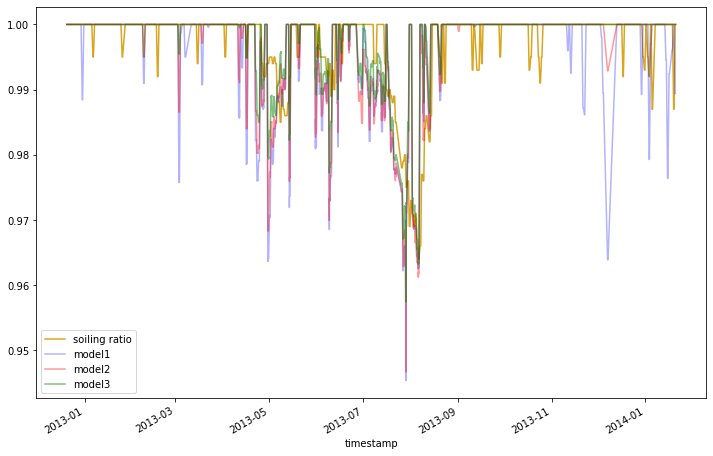

In [19]:
y_pred1 = predict(df_scaled, model1, feats, target)
y_pred2 = predict(df_scaled, model2, feats, target)
y_pred3 = predict(df_scaled, model3, feats, target)
derate1 = np.maximum(np.minimum(df_scaled.power/y_pred1,1),0.0)
print(type(derate1))
derate1 = derate1.rolling('1D', min_periods=1,center = True).median()
derate2 = np.maximum(np.minimum(df_scaled.power/y_pred2,1),0.0)
derate2 = derate2.rolling('1D', min_periods=1, center = True).median()
derate3 = np.maximum(np.minimum(df_scaled.power/y_pred3,1),0.0)
derate3 = derate3.rolling('1D', min_periods=1, center = True).median()
ax1 = df['soiling_derate'].plot(figsize=(12,8), color = 'goldenrod',label = 'soiling ratio')
ax1.plot(derate1, color = 'blue', alpha = 0.3, label = 'model1')
ax1.plot(derate2, color = 'red', alpha = 0.4, label = 'model2')
ax1.plot(derate3, color = 'green', alpha = 0.5, label = 'model3')
plt.legend()

## Modelling soiling ratio

In [20]:
sdd = df.soiling_derate.resample('D').mean()
sdd = sdd.fillna(method='ffill').copy()
sdd = sdd.fillna(method='bfill').copy()

### SRR Performance index

Filter Complete


/home/ipsarros/more_venv2/lib/python3.8/site-packages/rdtools/normalization.py:727: UserWarning: Fraction of excluded data (10.92%) exceeded threshold
  warnings.warn("Fraction of excluded data "
/home/ipsarros/more_venv2/lib/python3.8/site-packages/rdtools/normalization.py:727: UserWarning: Fraction of excluded data (10.92%) exceeded threshold
  warnings.warn("Fraction of excluded data "
/home/ipsarros/more_venv2/lib/python3.8/site-packages/rdtools/normalization.py:727: UserWarning: Fraction of excluded data (10.92%) exceeded threshold
  warnings.warn("Fraction of excluded data "
/home/ipsarros/more_venv2/lib/python3.8/site-packages/rdtools/normalization.py:727: UserWarning: Fraction of excluded data (10.92%) exceeded threshold
  warnings.warn("Fraction of excluded data "
/home/ipsarros/more_venv2/lib/python3.8/site-packages/rdtools/normalization.py:727: UserWarning: Fraction of excluded data (10.92%) exceeded threshold
  warnings.warn("Fraction of excluded data "
/home/ipsarros/more_

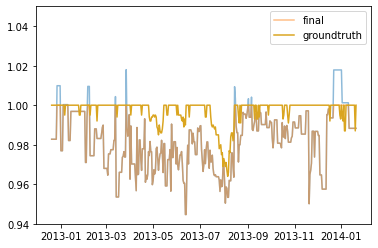

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pvlib
import rdtools
import itertools
from sklearn.metrics import mean_squared_error as mse


def run_rdtools_pipeline(df, time_filter, irradiance_filter, rd_filter, percentile_normal, insolation_normal):

    df_1 = df.copy()




    df_1.columns = ['poa', 'Tcell', 'Shortcircuitcurrent', 'power',
                   'dcurrent','Voltageatmax',
                   'Opencircuitvoltage', 'humidity', 'precipitation', 'dni', 'ghi', 'dhi', 'soiling_derate']
    df_1.index = pd.DatetimeIndex(df_1.index)
    df_1 = df_1.dropna()
    if time_filter:
        start = '12:00'
        end = '14:00'
        df_test = df_1.between_time(start, end)
    else: 
        df_test = df_1
    if irradiance_filter:    
    # 0 is the index of irradiance after setting the datetimeindex
        df_test = filter_col(df_test, 0, less_than=500, bigger_than=None)
    else: 
        df_test = df_1

    df_test = df_test.dropna()
    df_1 = df_test
    meta = {"gamma_pdc": -0.005,
        "power_dc_rated": 44.82#45.91#45.8 #45.91,#1000.0,
       }
    # There is some missing data, but we can infer the frequency from
    # the first several data points
    freq = pd.infer_freq(df_1.index[:10])

    # Then set the frequency of the dataframe.
    # It is recommended not to up- or downsample at this step
    # but rather to use interpolate to regularize the time series
    # to its dominant or underlying frequency. Interpolate is not
    # generally recommended for downsampling in this application.
    df_1 = rdtools.interpolate(df_1, df_1.index)
    
    # Calculate the expected power with a simple PVWatts DC model
    modeled_power = pvlib.pvsystem.pvwatts_dc(df_1['poa'], df_1['Tcell'], meta['power_dc_rated'],
                               meta['gamma_pdc'], 25)
    modeled_power_t = pvlib.pvsystem.pvwatts_dc(df_test['poa'], df_test['Tcell'], meta['power_dc_rated'],
                               meta['gamma_pdc'], 25)

   
    #added this:
    ##################################
    df_1 = df_1.resample('5T').median()
    #needed for golden:
    df_1 = df_1.interpolate()
    ##################################

    normalized, insolation = rdtools.normalize_with_expected_power(df_1['power'],
                                                                   modeled_power,
                                                                   df_1['poa'])

    
    
    df_1['normalized'] = normalized
    df_1['insolation'] = insolation
    
    if rd_filter:
        normalized_mask = rdtools.normalized_filter(df_1['normalized'])
        poa_mask = rdtools.poa_filter(df_1['poa'])
        tcell_mask = rdtools.tcell_filter(df_1['Tcell'])
        clip_mask = rdtools.clip_filter(df_1['power'], 'quantile', quantile=0.98)
        #clip_mask = rdtools.clip_filter(df_1['power'], 'xgboost')
        #clip_mask = rdtools.clip_filter(df_1['power'], 'logic')
        filtered = df_1[normalized_mask & poa_mask & tcell_mask & clip_mask]
    else: 
        filtered = df_1
    filtered = filtered[['power','insolation', 'normalized']]
   
    if insolation_normal:
        daily = rdtools.aggregation_insol(filtered.normalized, filtered.insolation,frequency = 'D')
    else:
        daily = filtered.power.resample('D').sum() / modeled_power.resample('D').sum()
    
    if percentile_normal and len(daily[daily > 0])>0:
        daily = daily / np.percentile(daily[daily > 0], 95)
        
    daily = daily.fillna(method='ffill', limit=14).copy()

    return daily, filtered


l = [False, True]

fig, ax = plt.subplots()
rmses = [] 
daily_list = []
masks = []    
daily, filtered = run_rdtools_pipeline(df, time_filter=True, irradiance_filter=True, rd_filter=True, percentile_normal=True, insolation_normal=True)
daily_smoothed = daily.reindex(sdd.index).rolling(1, center=True).median()

daily_smoothed = daily_smoothed.fillna(method='ffill').copy()
daily_smoothed = daily_smoothed.fillna(method='bfill').copy()
daily_smoothed_final = np.maximum(np.minimum(daily_smoothed,1),0.0)
ax.plot(sdd.index, daily_smoothed, alpha = 0.5) #, label = 'rdtools-normalized')
ax.plot(sdd.index, daily_smoothed_final, alpha = 0.5, label = 'final') #, label = 'rdtools-normalized')
ax.plot(sdd, color = 'goldenrod', label = 'groundtruth')
ax.set_ylim(0.94,1.05)
ax.legend()


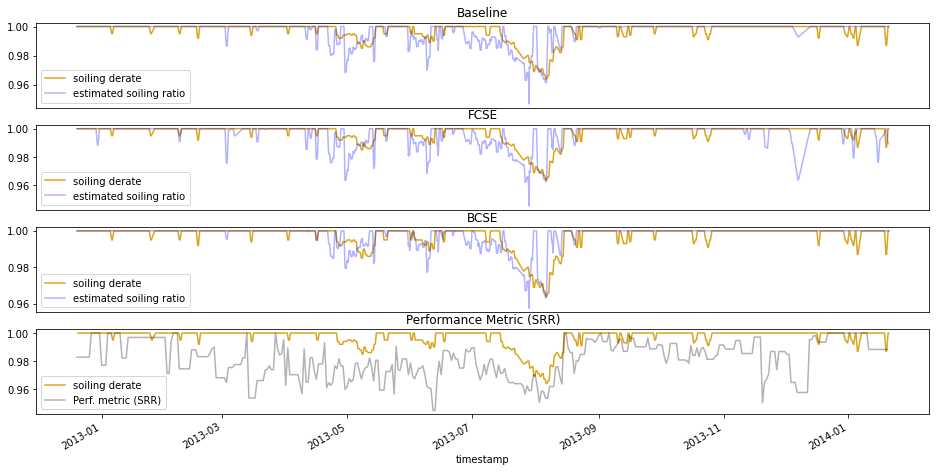

In [22]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(16,8))
#plt.suptitle(f'Changepoint Detection Methods')
axes = axes.ravel()


ax2 = axes[0]
ax2.set_title('Baseline')
#ax2.set_title('Model trained after manual cleanings')
y_pred2 = predict(df_scaled, model2, feats, target)
derate2 = np.maximum(np.minimum(df_scaled.power/y_pred2,1),0.0)
derate2 = derate2.rolling('1D', min_periods=1, center = True).median()
ax2 = df['soiling_derate'].plot(ax = ax2, color = 'goldenrod',label = 'soiling derate')
ax2.plot(derate2, color = 'blue', alpha = 0.3, label = 'estimated soiling ratio')
ax2.xaxis.set_visible(False)
ax2.legend()

ax1 = axes[1]
ax1.set_title('FCSE')
#ax1.set_title('Model trained after cleaning events obtained by Method 1')
y_pred1 = predict(df_scaled, model1, feats, target)
derate1 = np.maximum(np.minimum(df_scaled.power/y_pred1,1),0.0)
derate1 = derate1.rolling('1D', min_periods=1,center = True).median()
ax1 = df['soiling_derate'].plot(ax = ax1, color = 'goldenrod',label = 'soiling derate')
ax1.plot(derate1, color = 'blue', alpha = 0.3, label = 'estimated soiling ratio')
ax1.xaxis.set_visible(False)
ax1.legend()


ax3 = axes[2]
ax3.set_title('BCSE')
#ax3.set_title('Model trained after cleaning events obtained by Method 2')
y_pred3 = predict(df_scaled, model3, feats, target)
derate3 = np.maximum(np.minimum(df_scaled.power/y_pred3,1),0.0)
derate3 = derate3.rolling('1D', min_periods=1, center = True).median()
ax3 = df['soiling_derate'].plot(ax = ax3, color = 'goldenrod',label = 'soiling derate')
ax3.plot(derate3, color = 'blue', alpha = 0.3, label = 'estimated soiling ratio')
ax3.xaxis.set_visible(False)
ax3.legend()

ax4 = axes[3]
ax4.set_title('Performance Metric (SRR)')
ax4 = df['soiling_derate'].plot(ax = ax4, color = 'goldenrod',label = 'soiling derate')
#ax4.plot(p_index, color = 'black', alpha = 0.3, label = 'Perf. metric (SRR)')
ax4.plot(daily_smoothed_final, color = 'black', alpha = 0.3, label = 'Perf. metric (SRR)')

ax4.legend()
plt.show()

In [23]:
gt_daily = sdd

derate1_daily = derate1.resample('1D').median()
derate1_daily = derate1_daily.reindex(gt_daily.index).interpolate()

derate2_daily = derate2.resample('1D').median()
derate2_daily = derate2_daily.reindex(gt_daily.index).interpolate()

derate3_daily = derate3.resample('1D').median()
derate3_daily = derate3_daily.reindex(gt_daily.index).interpolate()

In [24]:
#Calculate RMSE for each model and srr
from sklearn.metrics import mean_squared_error as mse
gt = df['soiling_derate']
rmse1 = mse(gt_daily, derate1_daily, squared=False)
rmse2 = mse(gt_daily, derate2_daily, squared=False)
rmse3 = mse(gt_daily, derate3_daily, squared=False)
rmse_srr = mse(gt_daily, daily_smoothed_final, squared=False)
print(f'RMSE FCSE = ', rmse1)
print(f'RMSE Baseline = ', rmse2)
print(f'RMSE BCSE = ', rmse3)
print(f'RMSE SRR = ', rmse_srr)

RMSE FCSE =  0.007432672087941156
RMSE Baseline =  0.00581566810520564
RMSE BCSE =  0.005001817257477365
RMSE SRR =  0.019791814100865463


## Plot changepoints

In [25]:
daily_insolation = filtered['insolation'].resample('D').sum()
daily_prec = precipitation.resample("1D").sum().dropna()
daily, filtered = run_rdtools_pipeline(df, time_filter=True, irradiance_filter=True, rd_filter=True, percentile_normal=True, insolation_normal=True)

x = np.max(daily_prec)
for i in range(len(dates_wash_start)):
    daily_prec[dates_wash_start[i]:dates_wash_stop[i]] = x
    print(daily_prec[dates_wash_start[i]:dates_wash_stop[i]])
    
# Perform the SRR calculation
from rdtools.soiling import soiling_srr
cl = 68.2
#sr, sr_ci, soiling_info = soiling_srr(daily, daily_insolation, precipitation_daily= daily_prec, clean_criterion = 'precip_and_shift',
#                                      min_interval_length = 7,confidence_level=cl, clean_threshold= 'infer', method = 'half_norm_clean' ,  precip_threshold=0.1)
sr, sr_ci, soiling_info = soiling_srr(daily, daily_insolation, precipitation_daily= daily_prec, clean_criterion = 'precip_and_shift',
                                      min_interval_length = 7,confidence_level=cl, clean_threshold = 'infer', method = 'perfect_clean' ,  precip_threshold=0.1)

Filter Complete


/home/ipsarros/more_venv2/lib/python3.8/site-packages/rdtools/normalization.py:727: UserWarning: Fraction of excluded data (10.92%) exceeded threshold
  warnings.warn("Fraction of excluded data "
/home/ipsarros/more_venv2/lib/python3.8/site-packages/rdtools/normalization.py:727: UserWarning: Fraction of excluded data (10.92%) exceeded threshold
  warnings.warn("Fraction of excluded data "
/home/ipsarros/more_venv2/lib/python3.8/site-packages/rdtools/normalization.py:727: UserWarning: Fraction of excluded data (10.92%) exceeded threshold
  warnings.warn("Fraction of excluded data "
/home/ipsarros/more_venv2/lib/python3.8/site-packages/rdtools/normalization.py:727: UserWarning: Fraction of excluded data (10.92%) exceeded threshold
  warnings.warn("Fraction of excluded data "
/home/ipsarros/more_venv2/lib/python3.8/site-packages/rdtools/normalization.py:727: UserWarning: Fraction of excluded data (10.92%) exceeded threshold
  warnings.warn("Fraction of excluded data "
/home/ipsarros/more_

2013-03-11    1477.2
2013-03-12    1477.2
Freq: D, dtype: float64
2013-07-10    1477.2
2013-07-11    1477.2
Freq: D, dtype: float64
2013-08-14    1477.2
2013-08-15    1477.2
Freq: D, dtype: float64
2013-08-21    1477.2
2013-08-22    1477.2
Freq: D, dtype: float64
2013-08-26    1477.2
2013-08-27    1477.2
Freq: D, dtype: float64


In [26]:
df_cp = soiling_info['soiling_interval_summary']
starts_of_interv = df_cp.start

In [27]:
dates_changepoints1 = pd.DatetimeIndex(p_changepoints_stop.iloc[list(effective_cp1)])
dates_changepoints2 = pd.DatetimeIndex(p_changepoints_stop.iloc[list(effective_cp2)])

#### Method 1

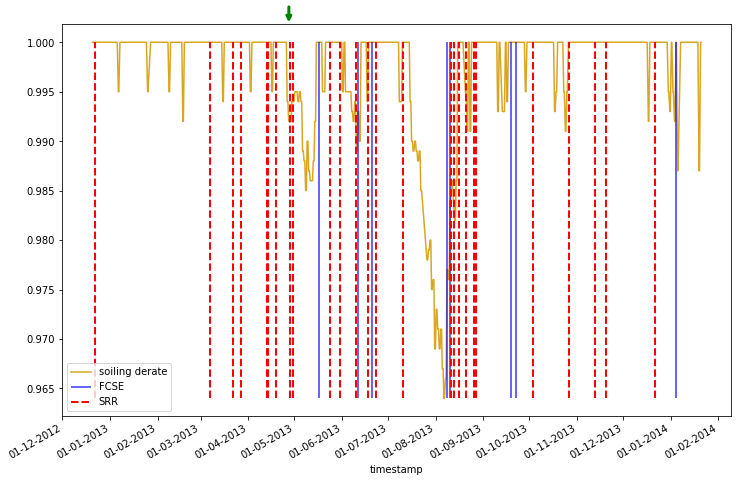

In [28]:
ymin = min(df['soiling_derate'].values)
ax1 = df['soiling_derate'].plot( color = 'goldenrod', label='soiling derate',figsize=(12,8))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax1.vlines(x=dates_changepoints1, ymin=ymin, ymax=1, colors='blue', alpha = 0.6,ls='-', lw= 2, label='FCSE')

ax1.vlines(x=starts_of_interv, ymin=ymin, ymax=1, colors='red', alpha = 1,ls='--', lw= 2, label='SRR')
ax1.annotate('', xy=(0.339, 1.05), xycoords='axes fraction', xytext=(0.339, 1), arrowprops=dict(arrowstyle="<-", color='green',lw =3))

b=0.92
#ax1.annotate('', xy=(b, 1.05), xycoords='axes fraction', xytext=(b, 1), arrowprops=dict(arrowstyle="<-", color='green',lw =3))

ax1.legend()
plt.show()

#### Method 2

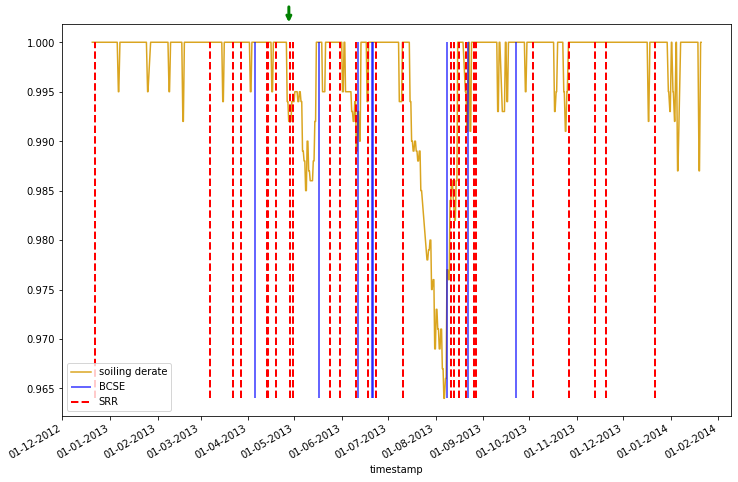

In [29]:
ymin = min(df['soiling_derate'].values)
ax2 = df['soiling_derate'].plot( color = 'goldenrod', label='soiling derate', figsize=(12,8))
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax2.vlines(x=dates_changepoints2, ymin=ymin, ymax=1, colors='blue', alpha = 0.6,ls='-', lw= 2, label='BCSE')

ax2.vlines(x=starts_of_interv, ymin=ymin, ymax=1, colors='red', alpha = 1,ls='--', lw= 2, label='SRR')
ax2.annotate('', xy=(0.339, 1.05), xycoords='axes fraction', xytext=(0.339, 1), arrowprops=dict(arrowstyle="<-", color='green',lw =3))
b=0.92
#ax2.annotate('', xy=(b, 1.05), xycoords='axes fraction', xytext=(b, 1), arrowprops=dict(arrowstyle="<-", color='green',lw =3))

ax2.legend()
plt.show()